In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#iris일기
iris_df = sns.load_dataset('iris').sample(frac=1).reset_index(drop=True)
iris_df.head(3)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.8,2.7,5.1,1.9,virginica
1,6.5,3.2,5.1,2.0,virginica
2,5.3,3.7,1.5,0.2,setosa


In [3]:
iris_df.shape

(150, 5)

In [14]:
iris_df.head((max(iris_df['sepal_length'])))
    

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [7.9] of <class 'float'>

In [35]:
# x와 y컬럼을 지정
x_columns = ['sepal_length','sepal_width','petal_length','petal_width']
y_column = 'species'


In [36]:
#y컬럼의 문자열값을 labelEncoder를 통해 숫자로 바꾼다
y_true_label_encoder = preprocessing.LabelEncoder()
y_true_encoded       = y_true_label_encoder.fit_transform(iris_df[y_column])
print(list(iris_df[y_column][:5]),'->',list(y_true_encoded[:5])) #샘플출력

['virginica', 'versicolor', 'virginica', 'setosa', 'virginica'] -> [2, 1, 2, 0, 2]


In [37]:
#k클러스터의 개수 2-9까지 조정하면서 KMeans 모델 생성 및 학습

In [38]:
kMeansModels              = dict() # k값별 모델 저장할 딕셔너리
kMeansModelPreds          = dict() # k값별 모델 예측 결과 저장할 딕셔너리
kMeansModelLabelEncoder   = dict() # k값별 라벨인코더 저장할 딕셔너리

sumSquaredDistancesList   = list() # 샘플과 클러스터 센터간 거리 제곱의 합 리스트
silhouetteScoreList       = list() # Silhouette Coefficient 평균 리스트

ks = [2,3,4,5,6,7,8,9] # k값으로 2부터 9까지 테스트한다
for k in ks: # k값 순회
    model = KMeans(n_clusters=k, random_state=0, n_init=100)  # k개 클러스터로 모델 생성
    cluster_labels = model.fit_predict(iris_df[x_columns]) # X컬럼으로 지정된 필드값으로 피팅
    
    y_pred_label_encoder = preprocessing.LabelEncoder() # 예측한 클러스터에서 사용할 라벨인코더
    # 초기 임의 값 (unknown 1, unknown 2...) 으로 인코딩한다
    y_pred_label_encoder.fit(np.array(['unknown ' + str(i+1) for i in range(0, k, 1)], dtype=object))
    for pred_label_num in range(0,k,1): # 각 클러스터 순회        
        # 해당 클러스터에서 가장 많이 출력한 실제 값의 인덱스를 구한다
        most_frequent_index = np.argmax(np.bincount(y_true_encoded[cluster_labels==pred_label_num]))
        # 구한 인덱스의 라벨을 구해서 해당클러스터 라벨로 업데이트한다
        y_pred_label_encoder.classes_[pred_label_num] = y_true_label_encoder.classes_[most_frequent_index]
    
    kMeansModels[k]     = model                       # 모델 저장
    kMeansModelPreds[k] = cluster_labels              # 모델 예측결과 저장     
    kMeansModelLabelEncoder[k] = y_pred_label_encoder # 라벨인코더 저장
    sumSquaredDistancesList.append(model.inertia_)    # # 샘플과 클러스터 센터간 거리 제곱의 합 저장
    silhouetteScoreList.append(silhouette_score(iris_df[x_columns].values, cluster_labels)) # Silhouette Score저장

In [39]:
# k(클러스터) 개수에 따라 "샘플과 클러스터 센터간 거리 제곱의 합"을 그래프로 그려본다.


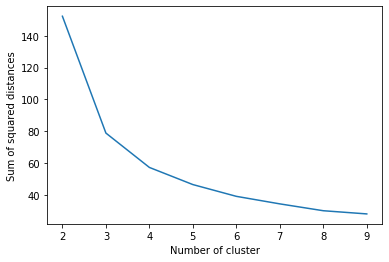

In [40]:
plt.plot(ks, sumSquaredDistancesList)
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distances")
plt.show()

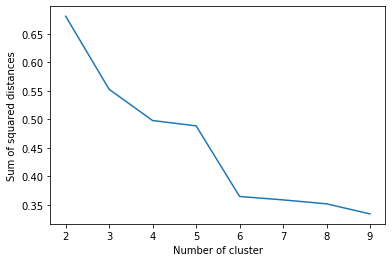

In [20]:
plt.plot(ks, silhouetteScoreList)
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distances")
plt.show()

In [21]:
#드롭다운에서 선택하면서 사용자와 상호작용이 가능! 동시에 그래프를 본다

In [45]:
def render_plot(x_col='petal_length', y_col='petal_width', k=3):
    y_pred        = kMeansModelPreds[k]        # 모델 예측값
    label_encoder = kMeansModelLabelEncoder[k] # 라벨인코더
    
    # 원본과 예측값을 합쳐 데이터셋을 준비
    mdf = pd.concat([iris_df, pd.DataFrame(label_encoder.inverse_transform(y_pred), columns=[y_column+'_pred'])], axis=1)
    
    plt.figure(figsize=(15,8)) # 출력 크기를 지정
    
    ddf = mdf[mdf[y_column] != mdf[y_column+'_pred']] # 실제라벨과 예측라벨이 틀린 경우 추출
    # X기호로 error임을 표시한다
    plt.scatter(x=ddf[x_col], y=ddf[y_col], c='black', marker='x', s=300, label='error') 
    
    colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black'] # 컬러값 리스트
    for (idx,cls) in enumerate(list(y_true_label_encoder.classes_)):
#         print(cls)
        ddf = mdf[mdf[y_column] == cls] # 실제라벨 데이터는 작은 점으로 출력
#         print(ddf[x_col])
        plt.scatter(x=ddf[x_col], y=ddf[y_col], c=colors[idx], marker='.', linewidths=3, s=50, label=cls)
        ddf = mdf[mdf[y_column+'_pred'] == cls] # 예측라벨 데이터는 큰 원으로 출력
        plt.scatter(x=ddf[x_col], y=ddf[y_col], c=colors[idx], marker='o', linewidths=13, s=2, label=cls+' pred')
        print(mdf)
    plt.legend();plt.xlabel(x_col);plt.ylabel(y_col)
    print('accuracy {:.2f}'.format(np.mean(mdf[y_column] == mdf[y_column+'_pred']))) # 정확도 출력
    plt.show()


In [46]:
from ipywidgets import interact

In [47]:
interact(render_plot, x_col=x_columns, y_col=x_columns, k=ks)

interactive(children=(Dropdown(description='x_col', index=2, options=('sepal_length', 'sepal_width', 'petal_le…

<function __main__.render_plot(x_col='petal_length', y_col='petal_width', k=3)>